# 📌 Problem Statement
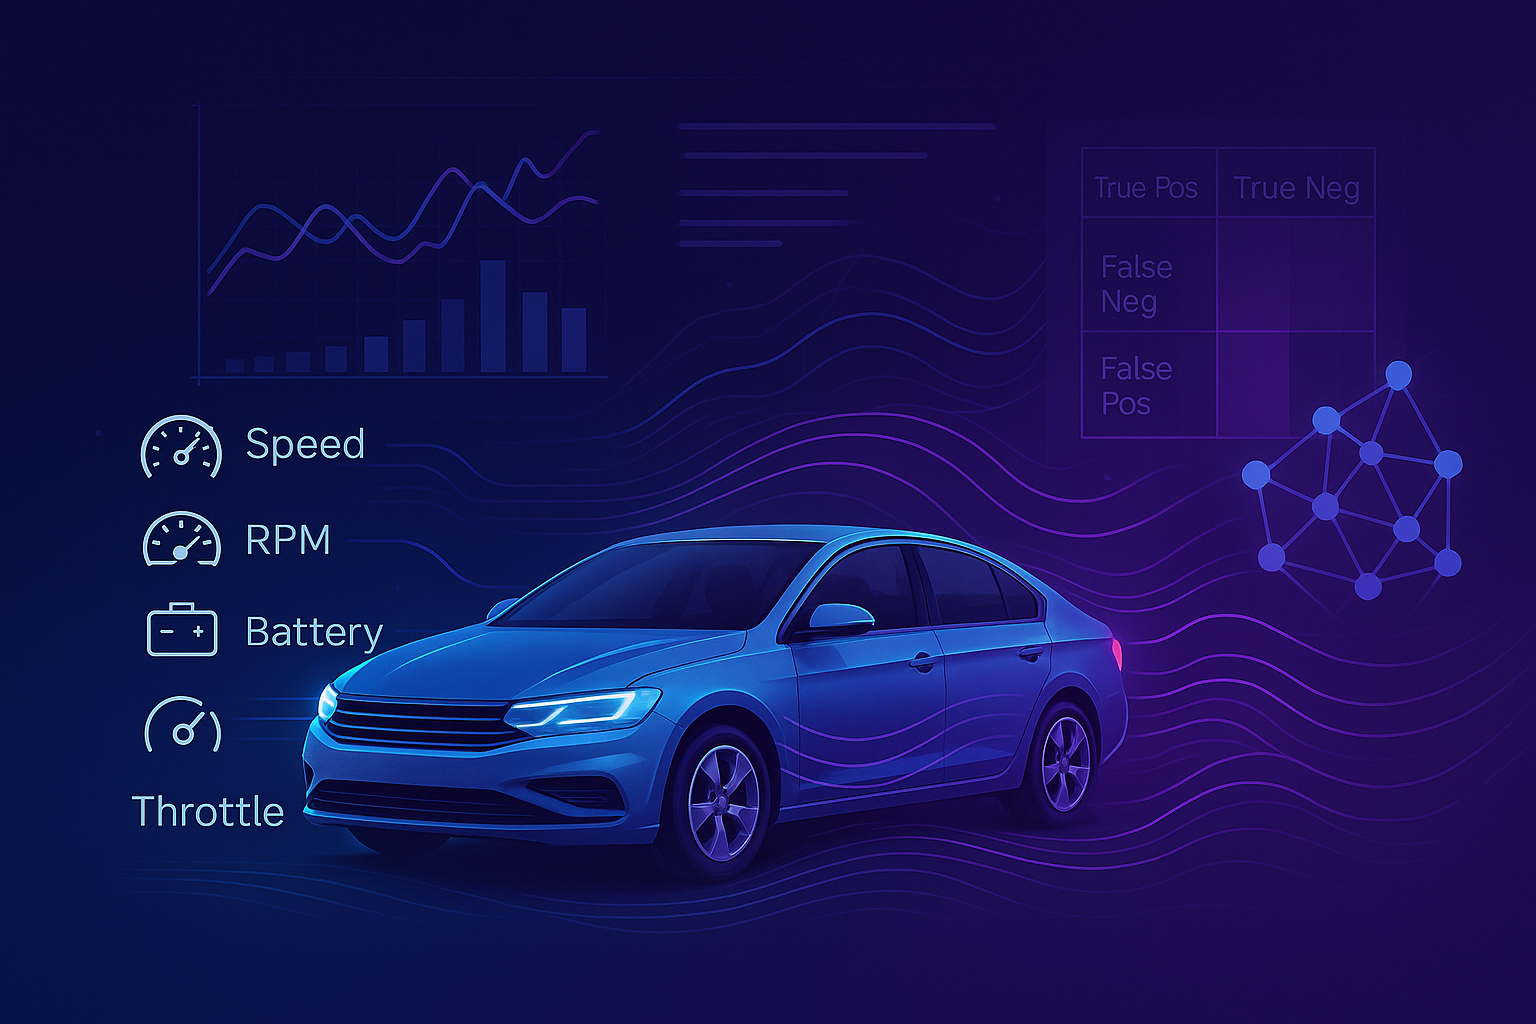
This project aims to detect vehicle status (normal/faulty) based on telematics data. We'll walk through a full data science workflow including EDA, preprocessing, modeling, and evaluation.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns



import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models

from sklearn.model_selection import GridSearchCV

from keras import models
import keras.models as keras_models

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, Input

from sklearn.utils import class_weight

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import jenkspy

import lazypredict.Supervised
from lazypredict.Supervised import LazyClassifier

import tqdm

from tqdm.notebook import tqdm
from tqdm import tqdm
import lazypredict.Supervised



from lightgbm import LGBMClassifier

import joblib

import gradio as gr


# 📥 Data Loading

In [2]:
base_path = r"D:\DeepLearning\TelematicVehicle\Data"

os.listdir(base_path)

['allcars.csv', 'allcars.xlsx', 'Data.rar', 'v2.csv']

In [47]:

file_path = os.path.join(base_path, 'allcars.csv')
df_allcars = pd.read_csv(file_path, low_memory=False)

file_v2 = os.path.join(base_path, 'v2.csv')
df_v2 = pd.read_csv(file_v2, low_memory=False)

def convert_numeric_columns(df, exclude=[]):
    for col in df.columns:
        if col not in exclude:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

df_allcars= convert_numeric_columns(df_allcars , exclude=['tripID', 'deviceID', 'accData', 'timeStamp'])
df_v2 = convert_numeric_columns(df_v2, exclude=['tripID', 'deviceID', 'accData', 'timeStamp'])


In [4]:
# Define data types for efficient and consistent DataFrame loading
dtype_dict = {
    'tripID'     : 'str',
    'deviceID'   : 'str',
    'accData'    : 'str',    # Raw acceleration data as string
    'gps_speed'  : 'float',  # GPS-based speed in km/h
    'battery'    : 'float',  # Battery voltage
    'cTemp'      : 'float',  # Coolant temperature
    'dtc'        : 'float',  # Diagnostic Trouble Code count
    'eLoad'      : 'float',  # Electrical load
    'iat'        : 'float',  # Intake air temperature
    'imap'       : 'float',  # Intake manifold absolute pressure
    'kpl'        : 'float',  # Kilometers per liter (fuel efficiency)
    'maf'        : 'float',  # Mass air flow
    'rpm'        : 'float',  # Revolutions per minute
    'speed'      : 'float',  # Vehicle speed in km/h
    'tAdv'       : 'float',  # Timing advance
    'tPos'       : 'float'   # Throttle position
}


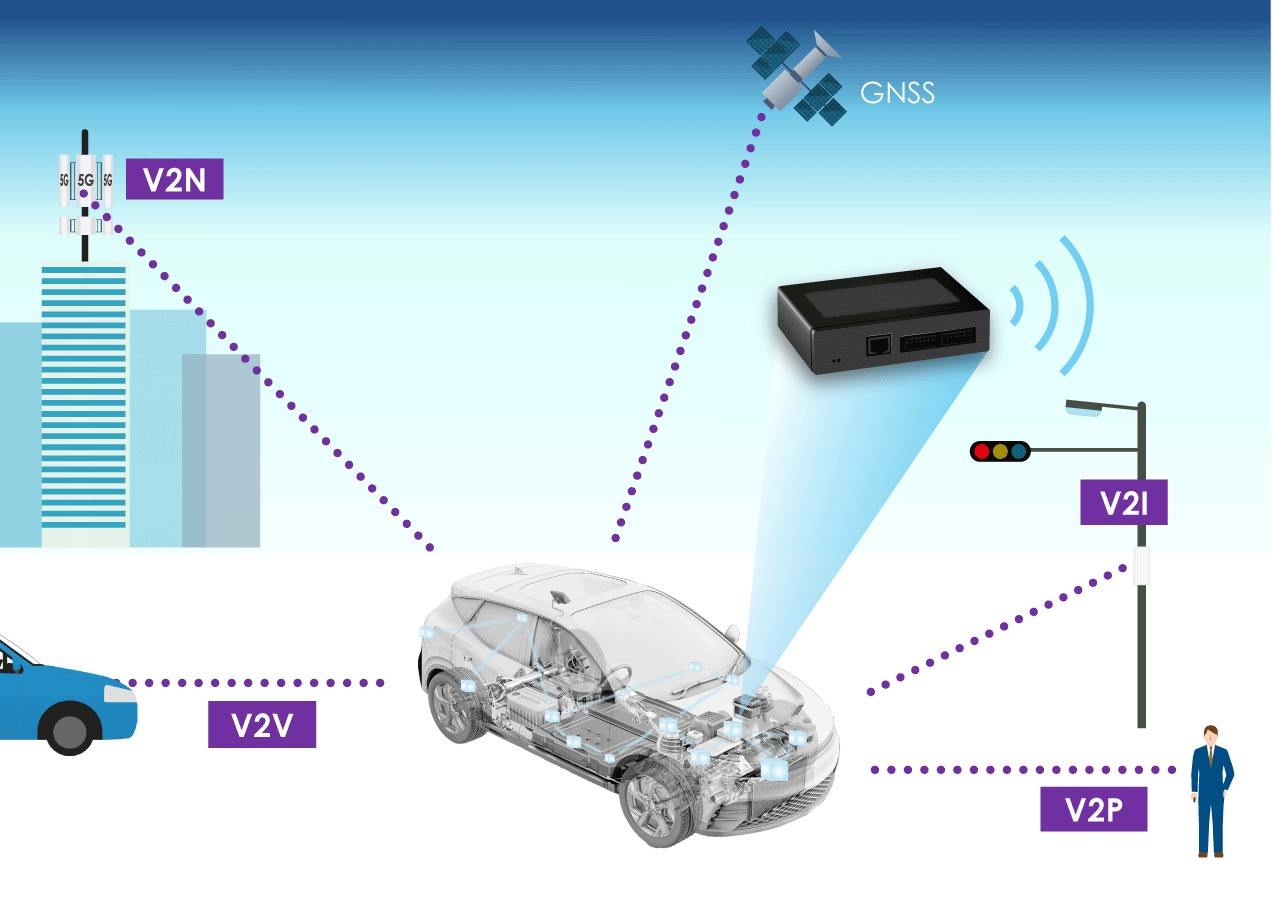

In [5]:
df_allcars['timeStamp'] = pd.to_datetime(df_allcars['timeStamp'], errors='coerce')


In [6]:
print(df_allcars['timeStamp'].head(5))
print(df_allcars['timeStamp'].dtype)


0   2017-10-31 18:45:59
1   2017-10-31 18:46:00
2   2017-10-31 18:46:01
3   2017-10-31 18:46:02
4   2017-10-31 18:46:03
Name: timeStamp, dtype: datetime64[ns]
datetime64[ns]


In [7]:
df_allcars['timeStamp'] = pd.to_datetime(df_allcars['timeStamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
print("✅ Time range in df_allcars:", df_allcars['timeStamp'].min(), "to", df_allcars['timeStamp'].max())



✅ Time range in df_allcars: 2017-08-30 00:00:00 to 2017-12-31 23:31:04


In [8]:
for col in df_allcars.columns:
    if col != 'tripID':
        df_allcars[col] = pd.to_numeric(df_allcars[col], errors='coerce')


In [9]:
def inspect_dataframe(df, name):
    print(f"\n📄 Inspecting `{name}`")
    print("=" * (13 + len(name)))
    print(f"🔹 Shape: {df.shape}")
    print("🔹 Columns:", ", ".join(df.columns))
    print("🔹 Preview:")
    display(df.head())

inspect_dataframe(df_allcars, "allcars.csv")


inspect_dataframe(df_v2, "v2.csv")




📄 Inspecting `allcars.csv`
🔹 Shape: (7214695, 18)
🔹 Columns: Unnamed: 0, timeStamp, tripID, accData, gps_speed, battery, cTemp, dtc, eLoad, iat, imap, kpl, maf, rpm, speed, tAdv, tPos, deviceID
🔹 Preview:


Unnamed: 0            timeStamp  tripID  accData  gps_speed  battery  \
0           0  1509475559000000000       0      NaN       2.20    14.48   
1           1  1509475560000000000       0      NaN       3.70    14.48   
2           2  1509475561000000000       0      NaN       3.90    14.54   
3           3  1509475562000000000       0      NaN       3.90    14.56   
4           4  1509475563000000000       0      NaN       4.70    14.48   

   cTemp  dtc  eLoad  iat  imap  kpl  maf     rpm  speed  tAdv  tPos  deviceID  
0    NaN  NaN  44.31  NaN   NaN 0.00 0.00  903.00   4.00   NaN 15.69         1  
1    NaN  NaN  35.29  NaN   NaN 0.00 0.00  938.00   6.00   NaN 15.29         1  
2    NaN  NaN  29.41  NaN   NaN 0.00 0.00 1044.50   7.00   NaN 14.90         1  
3    NaN  NaN  53.73  NaN   NaN 0.00 0.00 1102.00   7.00   NaN 17.65         1  
4    NaN  NaN  75.69  NaN   NaN 0.00 0.00 1626.50  10.00   NaN 23.53         1


📄 Inspecting `v2.csv`
🔹 Shape: (3120272, 17)
🔹 Columns: tripID, deviceID, timeStamp, accData, gps_speed, battery, cTemp, dtc, eLoad, iat, imap, kpl, maf, rpm, speed, tAdv, tPos
🔹 Preview:


tripID deviceID            timeStamp  \
0      1      0.0  2017-12-22 18:43:05   
1      1      0.0  2017-12-22 18:43:06   
2      1      0.0  2017-12-22 18:43:07   
3      1      0.0  2017-12-22 18:43:08   
4      1      0.0  2017-12-22 18:43:09   

                                             accData  gps_speed  battery  \
0  10c0f8e00448fa18c80515d30000000000000000000000...      24.26     0.00   
1  1138f8c804780a1ebdf718bcf919d10617c8e301b31017...      23.15     0.00   
2  10f0f89804480612c30010c30714ce0520b7f41dbdf118...      18.71     0.00   
3  10d0f84804480d15bd0210c9f822c80017caf81ccd0517...      16.48     0.00   
4  1090f8c80480041dc9081cc50815c60511c60112c40514...      17.41     0.00   

   cTemp  dtc  eLoad   iat  imap  kpl  maf     rpm  speed  tAdv  tPos  
0  66.00 0.00  28.63 40.00 97.00 0.00 0.00 1010.75  23.00  0.00  0.00  
1  66.00 0.00  33.73 40.00 98.00 0.00 0.00  815.50  21.00  0.00  0.00  
2  66.00 0.00  43.14 40.00 98.00 0.00 0.00  862.25  17.00  0.00  0.00  
3  66.00 0.00  41.57 40.00 97.00 0.00 0.00  817.00  17.00  0.00  0.00  
4  66.00 0.00  43.14 40.00 97.00 0.00 0.00  804.25  15.00  0.00  0.00

In [10]:
df_v2.head()

tripID deviceID            timeStamp  \
0      1      0.0  2017-12-22 18:43:05   
1      1      0.0  2017-12-22 18:43:06   
2      1      0.0  2017-12-22 18:43:07   
3      1      0.0  2017-12-22 18:43:08   
4      1      0.0  2017-12-22 18:43:09   

                                             accData  gps_speed  battery  \
0  10c0f8e00448fa18c80515d30000000000000000000000...      24.26     0.00   
1  1138f8c804780a1ebdf718bcf919d10617c8e301b31017...      23.15     0.00   
2  10f0f89804480612c30010c30714ce0520b7f41dbdf118...      18.71     0.00   
3  10d0f84804480d15bd0210c9f822c80017caf81ccd0517...      16.48     0.00   
4  1090f8c80480041dc9081cc50815c60511c60112c40514...      17.41     0.00   

   cTemp  dtc  eLoad   iat  imap  kpl  maf     rpm  speed  tAdv  tPos  
0  66.00 0.00  28.63 40.00 97.00 0.00 0.00 1010.75  23.00  0.00  0.00  
1  66.00 0.00  33.73 40.00 98.00 0.00 0.00  815.50  21.00  0.00  0.00  
2  66.00 0.00  43.14 40.00 98.00 0.00 0.00  862.25  17.00  0.00  0.00  
3  66.00 0.00  41.57 40.00 97.00 0.00 0.00  817.00  17.00  0.00  0.00  
4  66.00 0.00  43.14 40.00 97.00 0.00 0.00  804.25  15.00  0.00  0.00

In [11]:
df_allcars.shape


(7214695, 18)

In [12]:
rows, columns = df_allcars.shape
print(f"Rows: {rows}, Columns: {columns}")


Rows: 7214695, Columns: 18


In [13]:
print(f"df_allcars shape: {df_allcars.shape}")
print(f"df_v2 shape: {df_v2.shape}")

df_allcars shape: (7214695, 18)
df_v2 shape: (3120272, 17)


# 🔍 EDA (Exploratory Data Analysis)

*Convert Data Types in df_v2*

In [14]:
df_allcars.info()
df_v2.info()
df_allcars.isnull().sum()
df_v2.isnull().sum()


# Columns that should be numeric (based on df_allcars)
numeric_cols = ['gps_speed', 'battery', 'cTemp', 'dtc', 'eLoad', 'iat', 'imap', 'kpl',
                'maf', 'rpm', 'speed', 'tAdv', 'tPos']

# Convert to float, setting invalid entries to NaN
for col in numeric_cols:
    df_v2[col] = pd.to_numeric(df_v2[col], errors='coerce')

# Optionally convert tripID and deviceID as well
df_v2['tripID'] = pd.to_numeric(df_v2['tripID'], errors='coerce')
df_v2['deviceID'] = pd.to_numeric(df_v2['deviceID'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214695 entries, 0 to 7214694
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   timeStamp   int64  
 2   tripID      int64  
 3   accData     float64
 4   gps_speed   float64
 5   battery     float64
 6   cTemp       float64
 7   dtc         float64
 8   eLoad       float64
 9   iat         float64
 10  imap        float64
 11  kpl         float64
 12  maf         float64
 13  rpm         float64
 14  speed       float64
 15  tAdv        float64
 16  tPos        float64
 17  deviceID    int64  
dtypes: float64(14), int64(4)
memory usage: 990.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120272 entries, 0 to 3120271
Data columns (total 17 columns):
 #   Column     Dtype  
---  ------     -----  
 0   tripID     object 
 1   deviceID   object 
 2   timeStamp  object 
 3   accData    object 
 4   gps_speed  float64
 5   battery    float64
 6   cTemp      float64
 7   

# Check for Missing Values

In [15]:
print("Missing values in df_allcars:")
print(df_allcars.isnull().sum())

print("\nMissing values in df_v2:")
print(df_v2.isnull().sum())


Missing values in df_allcars:
Unnamed: 0          0
timeStamp           0
tripID              0
accData       6954317
gps_speed     2112146
battery       2112146
cTemp         5115495
dtc           5115495
eLoad         2112146
iat           5115495
imap          5115495
kpl           2112146
maf           2112146
rpm           2112146
speed               0
tAdv          5115495
tPos          2112146
deviceID            0
dtype: int64

Missing values in df_v2:
tripID       32
deviceID     32
timeStamp     0
accData       0
gps_speed    32
battery      32
cTemp        32
dtc          32
eLoad        32
iat          32
imap         32
kpl          32
maf          32
rpm          32
speed        32
tAdv         32
tPos         32
dtype: int64


In [16]:

num_duplicated_records = df_allcars.duplicated().sum()
print(f"Number of duplicated records is: {num_duplicated_records}")
df_allcars.drop_duplicates(inplace=True)
num_duplicated_records_after = df_allcars.duplicated().sum()
print(f"Number of duplicated records after deletion is: {num_duplicated_records_after}")


Number of duplicated records is: 0
Number of duplicated records after deletion is: 0


In [17]:
df_allcars.max(numeric_only=True)


Unnamed: 0                                            969209.00
timeStamp                                1514763064000000000.00
tripID                                                  1081.00
accData      18800600000000002015006110873347184318226688331...
gps_speed                                                333.20
battery                                                  255.00
cTemp                                                    255.00
dtc                                                      255.00
eLoad                                                    255.00
iat                                                      255.00
imap                                                     255.00
kpl                                                    23362.40
maf                                                      601.90
rpm                                                    15391.50
speed                                                    448.62
tAdv                                    

In [18]:
print(df_allcars['accData'].describe())
print(df_allcars['accData'].dtype)

count                                            260378.00
mean    72205025002112959241634134285803205434648336959...
std                                                    inf
min                                                   0.00
25%                                                   0.00
50%                                                   0.00
75%                                                   0.00
max     18800600000000002015006110873347184318226688331...
Name: accData, dtype: float64
float64


**Basic Dataset Comparison**

In [19]:
# Check for unique trip IDs
print("Unique tripIDs in df_allcars:", df_allcars['tripID'].nunique())
print("Unique tripIDs in df_v2:", df_v2['tripID'].nunique())

# Time range check
print("Time range in df_allcars:", df_allcars['timeStamp'].min(), "to", df_allcars['timeStamp'].max())
print("Time range in df_v2:", df_v2['timeStamp'].min(), "to", df_v2['timeStamp'].max())


Unique tripIDs in df_allcars: 1082
Unique tripIDs in df_v2: 431
Time range in df_allcars: 1504051200000000000 to 1514763064000000000
Time range in df_v2: 2017-11-18 16:23:30 to timeStamp


# Convert timeStamp to DateTime Format

In [19]:
df_allcars['timeStamp'] = pd.to_datetime(df_allcars['timeStamp'], errors='coerce')
df_v2['timeStamp'] = pd.to_datetime(df_v2['timeStamp'], errors='coerce')


# Initial EDA & Visualization

**Plot histogram**

In [88]:
df_v2['label'] = df_v2['dtc'].apply(lambda x: 1 if x > 0 else 0)


In [89]:
features = ['gps_speed', 'battery', 'cTemp', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos']

for feat in features:
    df_v2 = remove_outliers_by_class(df_v2, feature=feat, label_col='label')


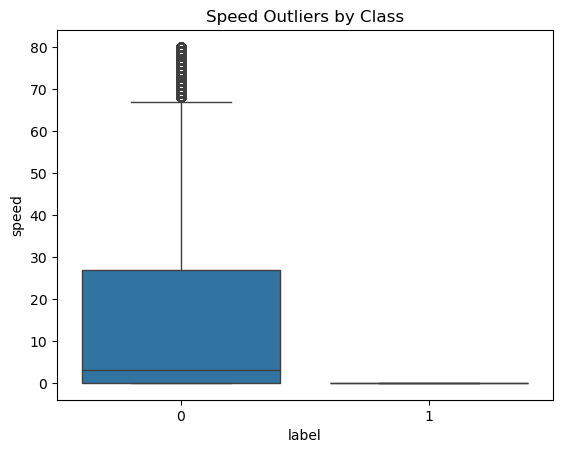

In [90]:
sns.boxplot(data=df_v2, x='label', y='speed')
plt.title('Speed Outliers by Class')
plt.show()

In [91]:
def remove_outliers_by_class(df, feature, label_col='label'):
    cleaned_df = pd.DataFrame()
    for label in df[label_col].unique():
        group = df[df[label_col] == label]
        Q1 = group[feature].quantile(0.25)
        Q3 = group[feature].quantile(0.75)
        IQR = Q3 - Q1
        mask = (group[feature] >= Q1 - 1.5 * IQR) & (group[feature] <= Q3 + 1.5 * IQR)
        cleaned_df = pd.concat([cleaned_df, group[mask]])
    return cleaned_df


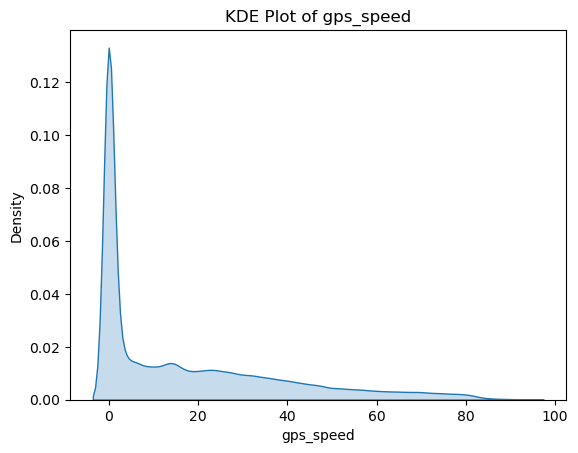

In [92]:
numeric_cols_v2 = df_v2.select_dtypes(include=['float64', 'int64']).columns.tolist()

sns.kdeplot(data=df_v2, x=numeric_cols_v2[0], fill=True)
plt.title(f'KDE Plot of {numeric_cols_v2[0]}')
plt.show()



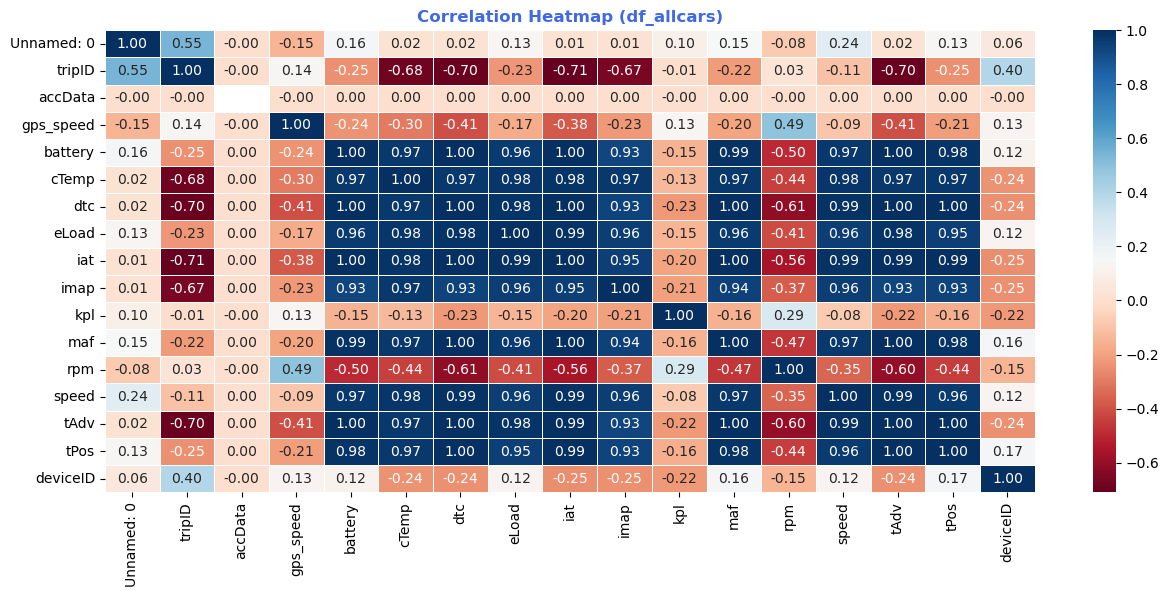

In [31]:
plt.figure(figsize=(15, 6))
dataplot = sns.heatmap(df_allcars.corr(numeric_only=True), cmap='RdBu', annot=True, fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap (df_allcars)", color='royalblue', weight='bold')
plt.show()



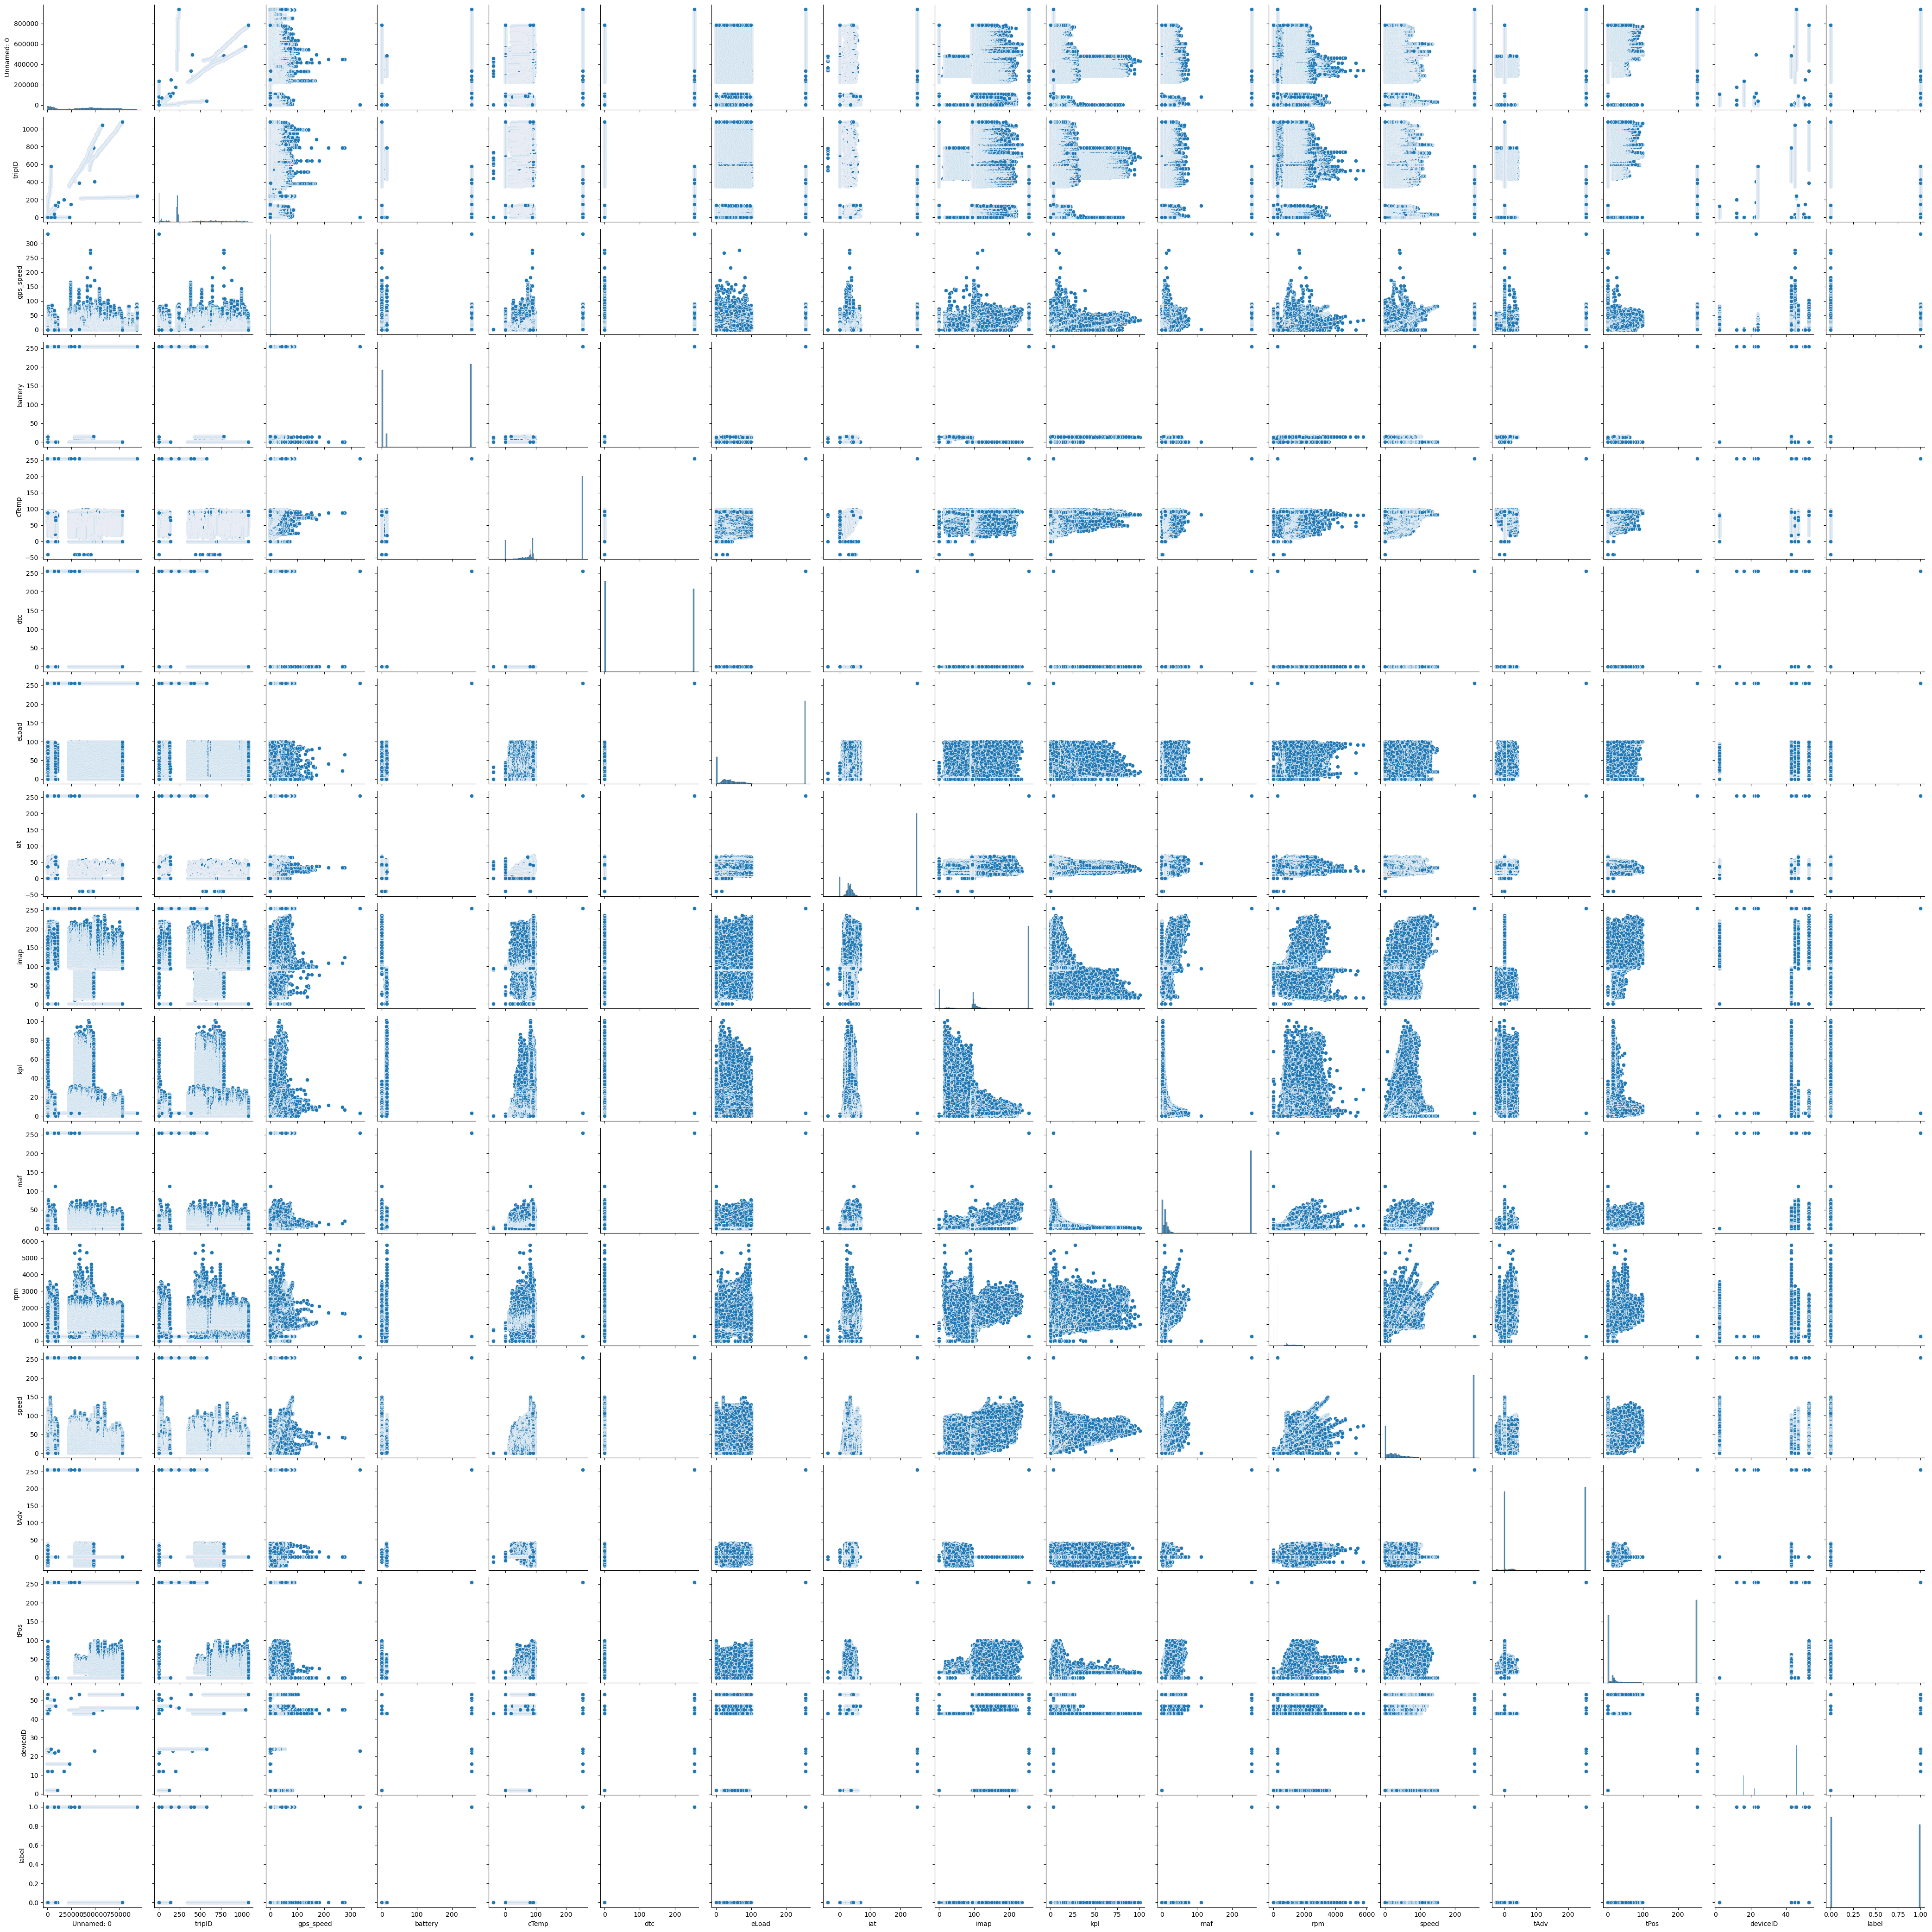

In [93]:
numeric_cols_allcars = df_allcars.select_dtypes(include=['float64', 'int64']).columns.tolist()

sns.pairplot(df_allcars[numeric_cols_allcars])
plt.show()

In [94]:
print(df_allcars.columns)


Index(['Unnamed: 0', 'timeStamp', 'tripID', 'accData', 'gps_speed', 'battery',
       'cTemp', 'dtc', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed',
       'tAdv', 'tPos', 'deviceID', 'label'],
      dtype='object')


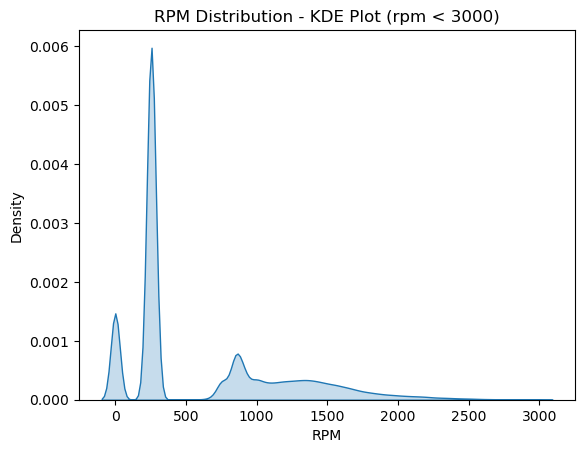

In [102]:
filtered_df = df_allcars[df_allcars['rpm'] < 3000]

sns.kdeplot(data=filtered_df, x='rpm', fill=True)
plt.title('RPM Distribution - KDE Plot (rpm < 3000)')
plt.xlabel("RPM")
plt.ylabel("Density")
plt.show()



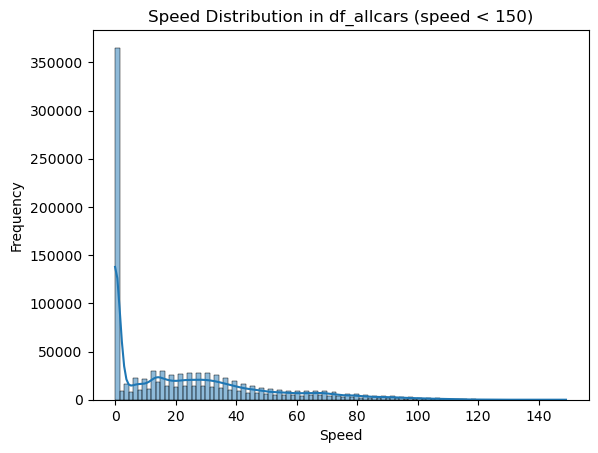

In [103]:
filtered_speed = df_allcars[df_allcars['speed'] < 150]['speed']

sns.histplot(filtered_speed, bins=100, kde=True)
plt.title("Speed Distribution in df_allcars (speed < 150)")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()


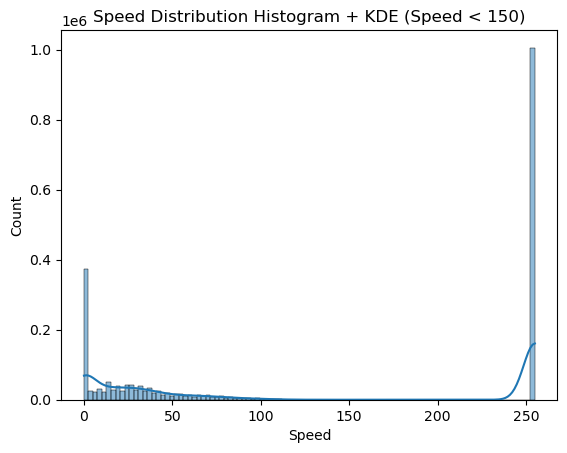

In [104]:
sns.histplot(filtered_df['speed'], bins=100, kde=True)
plt.title('Speed Distribution Histogram + KDE (Speed < 150)')
plt.xlabel("Speed")
plt.show()



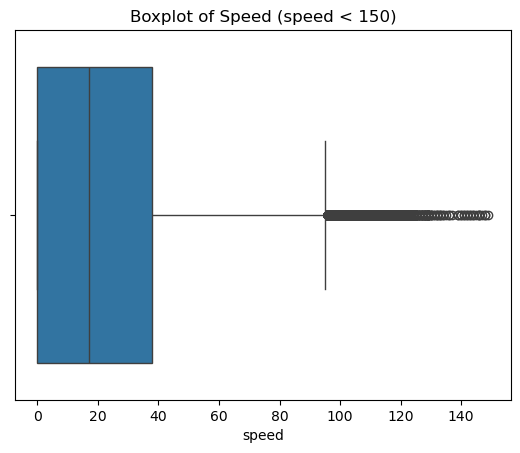

In [105]:
Q1 = df_allcars['speed'].quantile(0.25)
Q3 = df_allcars['speed'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

sns.boxplot(x=df_allcars[df_allcars['speed'] < 150]['speed'])
plt.title("Boxplot of Speed (speed < 150)")
plt.show()


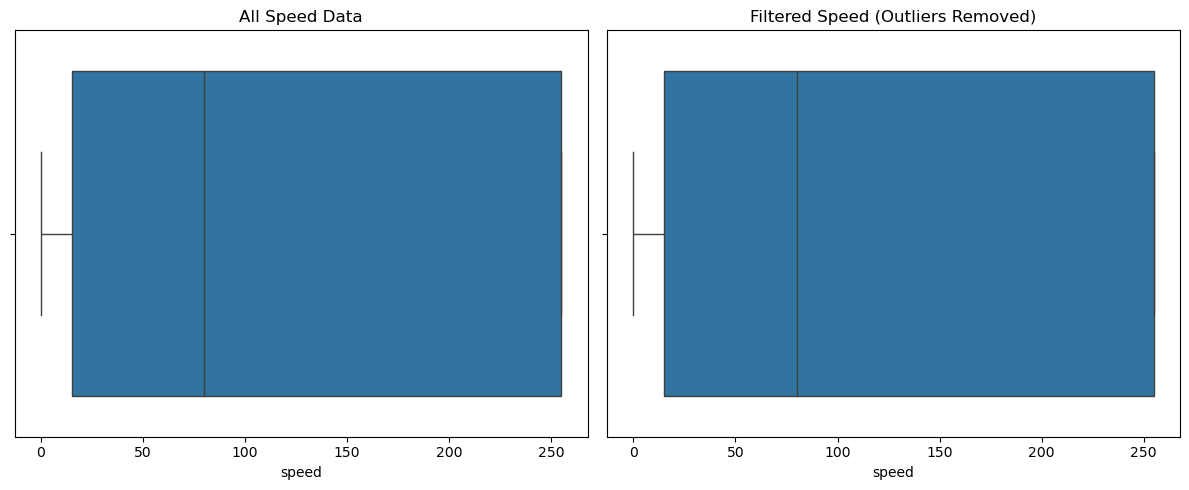

In [106]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
sns.boxplot(x=df_allcars['speed'])
plt.title("All Speed Data")


plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_df['speed'])
plt.title("Filtered Speed (Outliers Removed)")

plt.tight_layout()
plt.show()


Scatter Plot

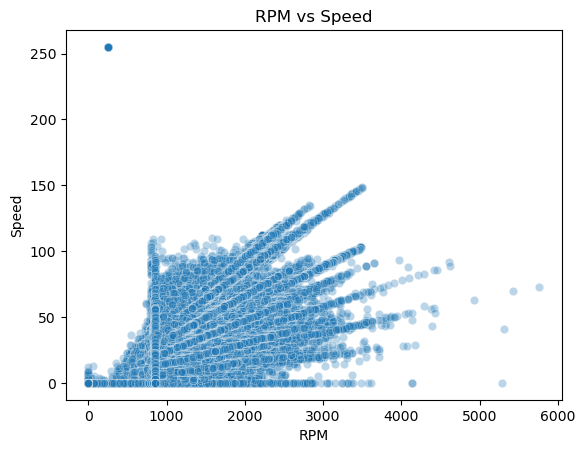

In [107]:
sns.scatterplot(data=df_allcars, x='rpm', y='speed', alpha=0.3)
plt.title("RPM vs Speed")
plt.xlabel("RPM")
plt.ylabel("Speed")
plt.show()


## 🔍 Sample Prediction

Pairplot

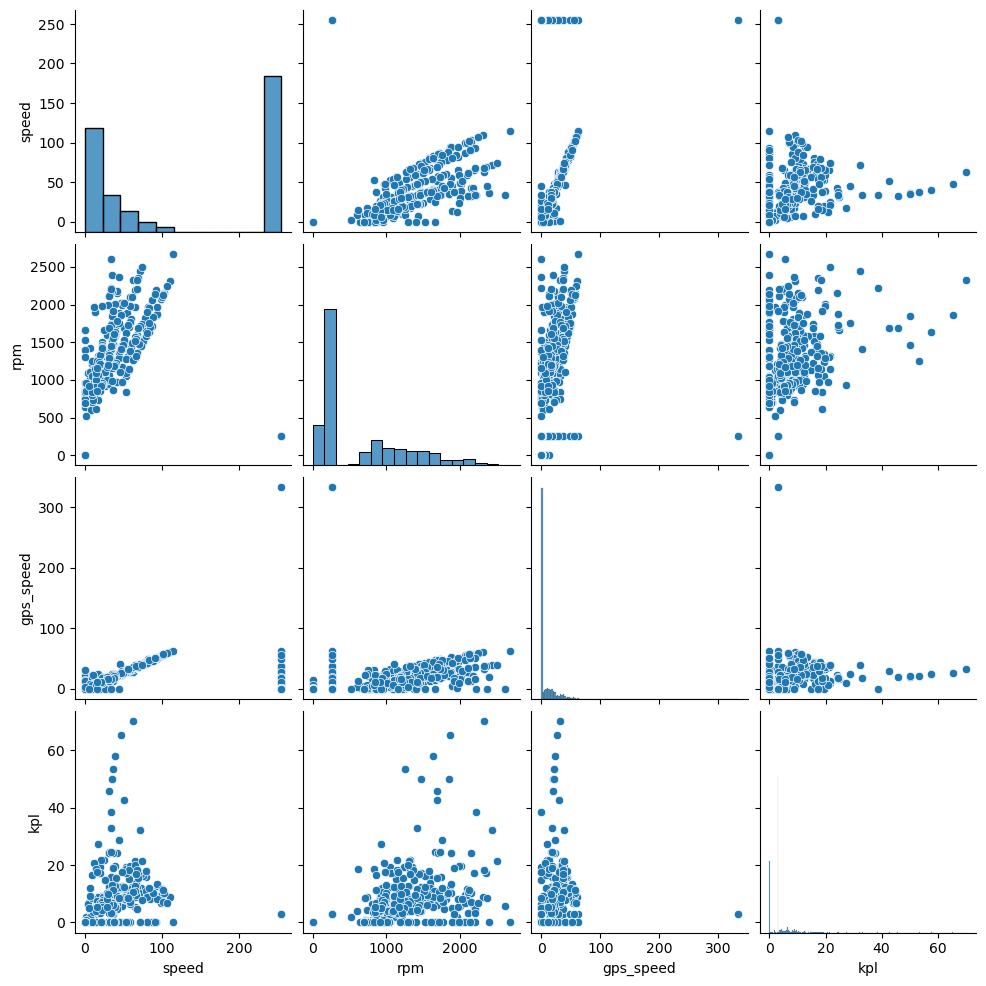

In [109]:
sample = df_allcars.sample(1000, random_state=42)
sns.pairplot(sample[['speed', 'rpm', 'gps_speed', 'kpl']])
plt.show()


# 🛠️ Preprocessing

Missing Values

**Calculate the cross-tabulation**

In [48]:
pd.crosstab(index=df_allcars['tripID'], columns=df_allcars['deviceID'])


deviceID    1    2      4      5     8     11    12   13    15      16  ...  \
tripID                                                                  ...   
0         1383  348    904  60948   198  2684  4403  431  1357  234403  ...   
1            1    5      6      1    11     4   983   20     9       0  ...   
2            3   10  27310    550  1193    10   712  139     5       0  ...   
3           43  652    604    883  1425   165    37  288     1       0  ...   
4           15  838     75   1385   257  1629     2  171     8       0  ...   
...        ...  ...    ...    ...   ...   ...   ...  ...   ...     ...  ...   
1077         0    0      0      0     0     0     0    0     0       0  ...   
1078         0    0      0      0     0     0     0    0     0       0  ...   
1079         0    0      0      0     0     0     0    0     0       0  ...   
1080         0    0      0      0     0     0     0    0     0       0  ...   
1081         0    0      0      0     0     0     0    0     0       0  ...   

deviceID    37    38    43    44    45     46    47     50   51    53  
tripID                                                                 
0          790  2624  3976  1032  2385  17669   780  36753  238  4658  
1            5   243     2     5    17      6     2     82   70    23  
2           20  2499    92  3281   298   1136   165     62  658   426  
3          415  1033   123   301   211    355  2038     32  667   577  
4         1361   252    56   147  1219    893   396     14  520   924  
...        ...   ...   ...   ...   ...    ...   ...    ...  ...   ...  
1077         0     0     0     0     0      0     0      0    0   165  
1078         0     0     0     0     0      0     0      0    0   581  
1079         0     0     0     0     0      0     0      0    0  1067  
1080         0     0     0     0     0      0     0      0    0   719  
1081         0     0     0     0     0      0     0      0    0  2055  

[1082 rows x 29 columns]

In [49]:
pd.crosstab(df_allcars['deviceID'], df_allcars['dtc'])


dtc       0.00    255.00
deviceID                
2         106460       0
12             0     216
16             0  234403
22             0   78013
23             0   10979
24             0   40139
43        203125     607
45        353440      19
46             0  600236
47         83784       0
50             0   40725
51             0     470
53        346495      89

In [50]:
pd.crosstab(df_allcars['deviceID'], df_allcars['dtc'], normalize='index') * 100


dtc       0.00    255.00
deviceID                
2         100.00    0.00
12          0.00  100.00
16          0.00  100.00
22          0.00  100.00
23          0.00  100.00
24          0.00  100.00
43         99.70    0.30
45         99.99    0.01
46          0.00  100.00
47        100.00    0.00
50          0.00  100.00
51          0.00  100.00
53         99.97    0.03

Box Plot / Violin Plot for Battery by DeviceID

In [51]:

print(df_allcars.isna().sum())


Unnamed: 0          0
timeStamp           0
tripID              0
accData        158868
gps_speed     2112146
battery       2112146
cTemp         5115495
dtc           5115495
eLoad         2112146
iat           5115495
imap          5115495
kpl           2112146
maf           2112146
rpm           2112146
speed               0
tAdv          5115495
tPos          2112146
deviceID            0
dtype: int64


## 🛠️ Data Preprocessing

In [52]:
df_allcars = df_allcars.dropna()

In [53]:
df_allcars = df_allcars.fillna(0)
print((df_allcars == float('inf')).sum())
df_allcars = df_allcars.replace([float('inf'), -float('inf')], 0)

Unnamed: 0    0
timeStamp     0
tripID        0
accData       0
gps_speed     0
battery       0
cTemp         0
dtc           0
eLoad         0
iat           0
imap          0
kpl           0
maf           0
rpm           0
speed         0
tAdv          0
tPos          0
deviceID      0
dtype: int64


In [54]:
numeric_df = df_allcars.select_dtypes(include=[np.number])
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]


In [55]:
numeric_df = df_allcars.select_dtypes(include=[np.number])
cond_number = np.linalg.cond(numeric_df.corr())

print(f"Condition number: {cond_number}")
numeric_df = df_allcars.select_dtypes(include=[np.number])

matrix = numeric_df.corr()

matrix += np.eye(matrix.shape[0]) * 1e-5


print(matrix)

Condition number: 129257.6735055844
            Unnamed: 0  tripID  gps_speed  battery  cTemp   dtc  eLoad   iat  \
Unnamed: 0        1.00    0.51       0.00     0.02   0.02  0.02   0.01  0.01   
tripID            0.51    1.00       0.25    -0.70  -0.68 -0.70  -0.70 -0.71   
gps_speed         0.00    0.25       1.00    -0.41  -0.30 -0.41  -0.35 -0.38   
battery           0.02   -0.70      -0.41     1.00   0.97  1.00   0.98  1.00   
cTemp             0.02   -0.68      -0.30     0.97   1.00  0.97   0.98  0.98   
dtc               0.02   -0.70      -0.41     1.00   0.97  1.00   0.98  1.00   
eLoad             0.01   -0.70      -0.35     0.98   0.98  0.98   1.00  0.99   
iat               0.01   -0.71      -0.38     1.00   0.98  1.00   0.99  1.00   
imap              0.01   -0.67      -0.23     0.93   0.97  0.93   0.96  0.95   
kpl               0.01    0.20       0.40    -0.21  -0.13 -0.23  -0.20 -0.20   
maf               0.03   -0.69      -0.39     1.00   0.97  1.00   0.99  1.00   
rpm 

In [56]:
numeric_df = df_allcars.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr().abs()


upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]


reduced_df = numeric_df.drop(columns=to_drop)

print("remove columns", to_drop)

remove columns ['cTemp', 'dtc', 'eLoad', 'iat', 'imap', 'maf', 'speed', 'tAdv', 'tPos']


# 🔬Train and test

In [57]:

X = df_allcars.drop(columns=['speed', 'timeStamp', 'tripID', 'deviceID', 'accData'])

X = X.select_dtypes(include='number')


y = df_allcars['speed']



In [58]:
features = ['gps_speed', 'battery', 'cTemp', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos']
df_allcars['label'] = df_allcars['dtc'].apply(lambda x: 1 if x > 0 else 0)
X = df_allcars[features]

y = df_allcars['label']
print(df_allcars.columns.tolist())


['Unnamed: 0', 'timeStamp', 'tripID', 'accData', 'gps_speed', 'battery', 'cTemp', 'dtc', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos', 'deviceID', 'label']


In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [60]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


# **🚀 Model**

## 🤖 Model Building

In [61]:

lazypredict.Supervised.notebook_tqdm = tqdm


In [62]:

value_counts = y.value_counts()
valid_classes = value_counts[value_counts >= 10].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]


In [63]:
from lazypredict.Supervised import LazyClassifier
from tqdm import tqdm
import lazypredict.Supervised
lazypredict.Supervised.notebook_tqdm = tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

clf = LazyClassifier(
    verbose=0,
    ignore_warnings=True,
    classifiers=[
        RandomForestClassifier,
        LogisticRegression,
        GaussianNB,
        DecisionTreeClassifier
    ]
)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

import pandas as pd
pd.set_option('display.max_rows', None)
print(models.sort_values("Accuracy", ascending=False))


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.96s/it]

                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
RandomForestClassifier      1.00               1.00     1.00      1.00   
LogisticRegression          1.00               1.00     1.00      1.00   
GaussianNB                  1.00               1.00     1.00      1.00   
DecisionTreeClassifier      1.00               1.00     1.00      1.00   

                        Time Taken  
Model                               
RandomForestClassifier       38.35  
LogisticRegression            1.95  
GaussianNB                    1.53  
DecisionTreeClassifier        1.99  


In [64]:
print(models.head())


                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
RandomForestClassifier      1.00               1.00     1.00      1.00   
LogisticRegression          1.00               1.00     1.00      1.00   
GaussianNB                  1.00               1.00     1.00      1.00   
DecisionTreeClassifier      1.00               1.00     1.00      1.00   

                        Time Taken  
Model                               
RandomForestClassifier       38.35  
LogisticRegression            1.95  
GaussianNB                    1.53  
DecisionTreeClassifier        1.99  


In [65]:
print(predictions)


                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
RandomForestClassifier      1.00               1.00     1.00      1.00   
LogisticRegression          1.00               1.00     1.00      1.00   
GaussianNB                  1.00               1.00     1.00      1.00   
DecisionTreeClassifier      1.00               1.00     1.00      1.00   

                        Time Taken  
Model                               
RandomForestClassifier       38.35  
LogisticRegression            1.95  
GaussianNB                    1.53  
DecisionTreeClassifier        1.99  


In [67]:

model = LGBMClassifier(verbosity=-1)
model.fit(X_train, y_train)


LGBMClassifier(verbosity=-1)

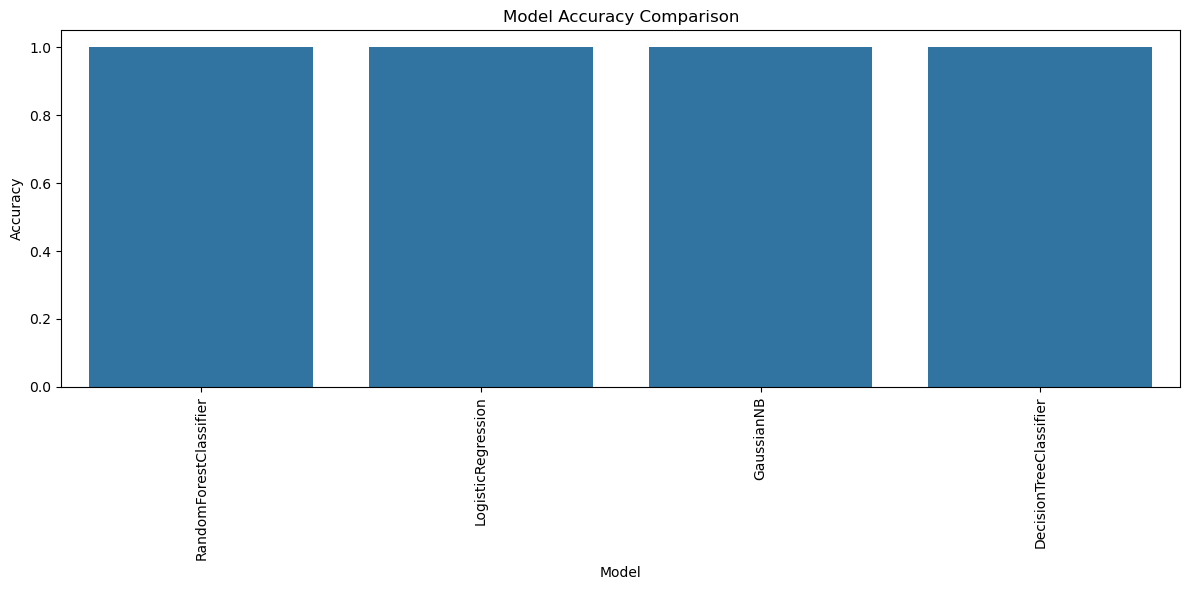

In [87]:
import matplotlib.pyplot as plt

def plot_model_comparison(model_df):
    model_df = model_df.sort_values(by='Accuracy', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=model_df.index, y='Accuracy', data=model_df)
    plt.xticks(rotation=90)
    plt.title('Model Accuracy Comparison')
    plt.tight_layout()
    plt.show()
plot_model_comparison(models)


**⚡joblib**

In [64]:

joblib.dump(model, 'best_telematics_model.pkl')

['best_telematics_model.pkl']

In [65]:
def predict_driving_style(speed, rpm, battery, maf, tPos, *args) :
    input_array = np.array([[speed, rpm, battery, maf, tPos, *args]])
    input_scaled = scaler.transform(input_array)
    prediction = model.predict(input_scaled)
    return prediction[0]

gr.Interface(
    fn=predict_driving_style,
    inputs=["number"] * 12,
    outputs="text",
    title="Telematics Driving Style Predictor"
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [67]:
sample_input = X_test[0].reshape(1, -1)
prediction = model.predict(sample_input)
print("Predicted Driving Style:", prediction[0])


Predicted Driving Style: 0


In [68]:
joblib.dump(model, "telematics_model.pkl")

joblib.dump(scaler, "telematics_scaler.pkl")

['telematics_scaler.pkl']

 **✔ Feature Importances**

In [69]:
feature_names = X.columns


importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Importance (LGBM)")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 1 Axes>

**🚗confusion matrix & classification report**

In [71]:
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218661
           1       1.00      1.00      1.00    201179

    accuracy                           1.00    419840
   macro avg       1.00      1.00      1.00    419840
weighted avg       1.00      1.00      1.00    419840



<Figure size 600x400 with 2 Axes>

**💪 Gradio**

In [72]:
odel = joblib.load("telematics_model.pkl")
scaler = joblib.load("telematics_scaler.pkl")


def predict(speed, rpm, battery, cTemp, eLoad, iat, imap, maf, tAdv, tPos):
    input_data = np.array([[speed, rpm, battery, cTemp, eLoad, iat, imap, maf, tAdv, tPos]])
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)
    return prediction[0]


gr.Interface(
    fn=predict,
    inputs=[
        gr.Number(label="Speed"),
        gr.Number(label="RPM"),
        gr.Number(label="Battery"),
        gr.Number(label="Coolant Temp"),
        gr.Number(label="Engine Load"),
        gr.Number(label="Intake Air Temp"),
        gr.Number(label="Intake MAP"),
        gr.Number(label="MAF"),
        gr.Number(label="Timing Advance"),
        gr.Number(label="Throttle Position")
    ],
    outputs="text",
    title="Driving Style Classifier (Calm / Normal / Aggressive)"
).launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# 🛸CNN

D-CNN


In [82]:
features = ['gps_speed', 'battery', 'cTemp', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos']

# بررسی وجود ستون‌ها
for f in features + ['label']:
    if f not in df_v2.columns:
        print(f"⚠️ ستون '{f}' در df_v2 موجود نیست!")

# بازسازی برچسب در صورت نیاز
if 'label' not in df_v2.columns:
    df_v2['label'] = df_v2['dtc'].apply(lambda x: 1 if x > 0 else 0)

# آماده‌سازی داده
X = df_v2[features].values
y = df_v2['label'].values


In [84]:
df_v2['label'] = df_v2['dtc'].apply(lambda x: 1 if x > 0 else 0)

features = ['gps_speed', 'battery', 'cTemp', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos']
X = df_v2[features].values
y = df_v2['label'].values

sequence_length = 10  

n_features = X.shape[1]


def reshape_sequences(X, y, seq_len):
    num_samples = len(X) - seq_len
    X_seq = np.array([X[i:i+seq_len] for i in range(num_samples)])
    y_seq = y[seq_len:]  
    return X_seq, y_seq

X_seq, y_seq = reshape_sequences(X, y, sequence_length)


In [85]:
n_classes = 2  

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(sequence_length, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8, 64)               │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          25,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,270 (110.43 KB)

 Trainable params: 28,270 (110.43 KB)

 Non-trainable params: 0 (0.00 B)

# 🧠 Modeling with Pipeline

In [71]:
model_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [0.85, 0.90, 0.87]
})

display(model_df.sort_values("Accuracy", ascending=False))


Model  Accuracy
1        Random Forest      0.90
2                  SVM      0.87
0  Logistic Regression      0.85

In [72]:

# Load your v2.csv (assuming you've already mounted the drive and read df_v2)
df = df_v2.copy()

# Convert gps_speed to numeric and clean it
df.loc[:, 'gps_speed'] = df['gps_speed'].astype(float)
df.loc[:, 'acceleration'] = df.groupby('tripID')['gps_speed'].diff().fillna(0)


# Derive features
df['acceleration'] = df.groupby('tripID')['gps_speed'].diff().fillna(0)
df['angle_change'] = df.groupby('tripID')['acceleration'].diff().fillna(0)
df['acceleration_squared'] = df['acceleration'] ** 2
df['angle_change_squared'] = df['angle_change'] ** 2

# Select features
features = ['gps_speed', 'acceleration', 'angle_change', 'acceleration_squared', 'angle_change_squared']
df_features = df[['tripID'] + features].copy()

# Normalize to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_features[features] = scaler.fit_transform(df_features[features])

# Build X array (shape: samples × 300 × 5)
X = []
trip_ids_used = []
for trip_id in df_features['tripID'].unique():
    trip_data = df_features[df_features['tripID'] == trip_id][features].values
    if len(trip_data) >= 300:
        X.append(trip_data[:300])
        trip_ids_used.append(trip_id)

X = np.array(X)
print("✅ X shape:", X.shape)

✅ X shape: (542, 300, 5)


In [73]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])


In [74]:
# Create y using trip_ids_used from above
trip_stats = df.groupby('speed').agg({'speed': 'mean'})

trip_stats['label'] = trip_stats['speed'].apply(lambda x: 1 if x > 65 else 0)

X = trip_stats[['speed']]
y = trip_stats['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [75]:
model = Sequential([
    Input(shape=(1,)),  # چون فقط یک ویژگی عددی داریم (speed)
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # برای binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5037 - loss: 3.0402 - val_accuracy: 0.5667 - val_loss: 2.0685
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5046 - loss: 3.1719 - val_accuracy: 0.5667 - val_loss: 1.8214
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5608 - loss: 2.9912 - val_accuracy: 0.5667 - val_loss: 1.7227
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5638 - loss: 1.9021 - val_accuracy: 0.5667 - val_loss: 1.6604
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5679 - loss: 2.2948 - val_accuracy: 0.5667 - val_loss: 1.5538
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5563 - loss: 2.4069 - val_accuracy: 0.5667 - val_loss: 1.5613
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5779 - loss: 2.0407 - val_accuracy: 0.5667 - val_loss: 1.4778
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6775 - loss: 1.3234 - val_accuracy: 0.5667 - val_loss: 1.3643


In [77]:

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

In [78]:
model = Sequential([
    Input(shape=(1,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4537 - loss: 22.1020 - val_accuracy: 0.4333 - val_loss: 23.7062
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4087 - loss: 21.1403 - val_accuracy: 0.4333 - val_loss: 21.1314
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4317 - loss: 18.1234 - val_accuracy: 0.4333 - val_loss: 18.6114
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4900 - loss: 14.3503 - val_accuracy: 0.4333 - val_loss: 16.1898
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4546 - loss: 13.5437 - val_accuracy: 0.4333 - val_loss: 13.7875
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4358 - loss: 11.7439 - val_accuracy: 0.4333 - val_loss: 11.4179
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3765 - loss: 10.6713 - val_accuracy: 0.4333 - val_loss: 9.0630
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4387 - loss: 7.6184 - val_accuracy: 0.4333 - val_

# 📈 Model Evaluation

In [81]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()


y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

<Figure size 640x480 with 1 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.57      1.00      0.72        17

    accuracy                           0.57        30
   macro avg       0.28      0.50      0.36        30
weighted avg       0.32      0.57      0.41        30



In [82]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5667 - loss: 0.5289
Test Loss: 0.5289105772972107
Test Accuracy: 0.5666666626930237


In [83]:
predictions = model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:

sns.histplot(data=df, x='speed', hue='speed_group', palette='Set2', multiple='stack')
plt.title('Speed Grouping by Jenks Breaks')
plt.show()

## 💾 Save Trained Model

In [ ]:
model.save('my_model.h5')
